In [28]:
from src import Modeler, Processor, Reader
import pandas as pd
from datetime import datetime
from sklearn import metrics, model_selection, preprocessing, inspection
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import time

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Using the US Census regions from here: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
south_atlantic_states = [
    10   # Delaware
    , 11 # DC
    , 12 # Florida
    , 13 # Georgia
    , 24 # Maryland
    , 37 # North Carolina
    , 45 # South Carolina
    , 51 # Virginia
    , 54 # West Virginia
]
state_filter = south_atlantic_states

In [3]:
state_dict = {
    'code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

state_code_map = pd.DataFrame(data=state_dict)

## Loading data

In [4]:
# Instantiate preprocessor
preprocessor = Processor.PreProcessor(state_filter=state_filter)

In [5]:
# Put data into a df to work with
df = preprocessor.get_processed_data()

/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])
/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])


In [6]:
# Export data to csv so that the data does not have to be recreated each run
df.to_csv('COVID_Analysis_Data.csv',index=False)
# Show data
df.head()

,FIPS_10001,FIPS_10003,FIPS_10005,FIPS_11001,FIPS_12001,FIPS_12003,FIPS_12005,FIPS_12007,FIPS_12009,FIPS_12011,...,is_metro,Series_Complete_Pop_Pct_UR_Equity,cases,deaths,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,25.142857,0.142857,3.428571,3.857143,3.428571,0.285714,0.285714,0.285714
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.714286,0.285714,4.714286,3.428571,3.857143,0.285714,0.285714,0.285714
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,27.857143,0.285714,6.142857,4.714286,3.428571,0.0,0.285714,0.285714
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,22.857143,0.428571,8.714286,6.142857,4.714286,0.0,0.0,0.285714
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.0,0.571429,14.428571,8.714286,6.142857,0.142857,0.0,0.0


In [7]:
# Load data
#df = pd.read_csv("COVID_Analysis_Data.csv", dtypes={'date':''})

In [8]:
df.shape

(289884, 704)

## Split into train and test

In [9]:
modeler = Modeler.Modeler()

In [10]:
# Split data into training and test dataset:
train_end_date = '2021-06-14'
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(df, train_end_date)

### Unpivoted data

In [11]:
unpivoted_df = preprocessor.get_processed_data_without_fips_as_columns(set_current_data=False)

/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])
/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])


In [12]:
unpivoted_cases = unpivoted_df[['date', 'FIPS', 'cases']].copy()
unpivoted_cases['STATE'] = unpivoted_cases['FIPS'].apply(lambda x: x[:2])
unpivoted_cases = unpivoted_cases.merge(state_code_map, left_on='STATE', right_on='code', how='left')

In [13]:
unpivoted_cases_test = unpivoted_cases[unpivoted_cases['date'] > train_end_date]

In [14]:
unpivoted_deaths = unpivoted_df[['date', 'FIPS', 'deaths']].copy()
unpivoted_deaths['STATE'] = unpivoted_deaths['FIPS'].apply(lambda x: x[:2])
unpivoted_deaths = unpivoted_deaths.merge(state_code_map, left_on='STATE', right_on='code', how='left')

In [15]:
unpivoted_deaths_test = unpivoted_deaths[unpivoted_deaths['date'] > train_end_date]

## Plotting functions

In [16]:
def plot_predictions(y_test, y_pred, model_name=None):
    plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, color='none', edgecolor='b')
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    if model_name:
        plt.title(f'{model_name}: Actuals vs Predicted', fontsize=16)
    else:
        plt.title('Actuals vs Predicted', fontsize=16)
    plt.show()
    
def plot_predictions_w_state(y_test, y_pred, unpivoted_test_df, model_name=None):
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=y_test, y=y_pred, hue=unpivoted_test_df['state_name'])
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    if model_name:
        plt.title(f'{model_name}: Actuals vs Predicted by state', fontsize=16)
    else:
        plt.title('Actuals vs Predicted by state', fontsize=16)
    plt.show()
    
def plot_residuals(X_test, residuals, model_name=None):
    plt.figure(figsize=(18, 6))
    sns.scatterplot(x=df['date'], y=residuals, color='none', edgecolor='r')
    if model_name:
        plt.title(f'{model_name}: Residuals', fontsize=16)
    else:
        plt.title('Residuals', fontsize=16)
    plt.show()
    
def plot_residuals_w_state(X_test, residuals, unpivoted_test_df, model_name=None):
    plt.figure(figsize=(18, 6))
    sns.scatterplot(x=df['date'], y=residuals, hue=unpivoted_test_df['state_name'])
    if model_name:
        plt.title(f'{model_name}: Residuals by state', fontsize=16)
    else:
        plt.title('Residuals by state', fontsize=16)
    plt.show()

## Modeling functions

In [17]:
def run_full_pipeline(model, X_train, y_train, X_test, y_test, unpivoted_test_df, model_name=None):
    if model_name:
        print(f'{model_name}')
    # Cross validate and report scores:
    scores = modeler.cv_model(model, X_train, y_train)
    print('Cross-Validation Scores:')
    for k, v in scores.items():
        print(f'\t{k}: {round(v[0],2)} +/- {round(v[1],2)}')
    # Test data
    start = time.time()
    y_pred, rmse, r2, fit_time, fit_predict_time = modeler.test_model(model, X_train, y_train, X_test, y_test)
    residuals = (y_test - y_pred)
    print(f'Time to train model: {fit_time}')
    # Plots
    plot_predictions(y_test, y_pred, model_name)
    plot_residuals(X_test, residuals, model_name)
    plot_predictions_w_state(y_test, y_pred, unpivoted_test_df, model_name)
    plot_residuals_w_state(X_test, residuals, unpivoted_test_df, model_name)
    return y_pred, residuals, rmse, r2, fit_time

# Gradient Boosting

In [18]:
gb_model = GradientBoostingRegressor()

In [19]:
# Cases
gb_model.fit(X_train, y_train_cases)

y_pred_cases = gb_model.predict(X_test)

In [20]:
mse = metrics.mean_squared_error(y_test_cases, y_pred_cases)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 2335.6488


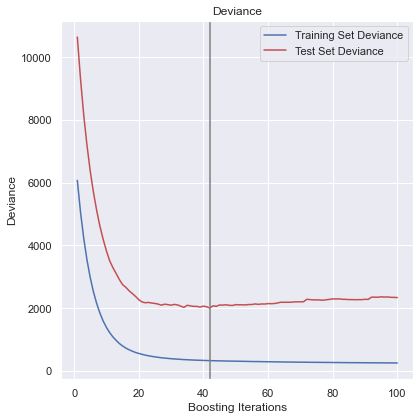

In [26]:
# Adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-training-deviance
number_of_estimators = 100
test_score = np.zeros((number_of_estimators,), dtype=np.float64)
for i, y_pred_cases in enumerate(gb_model.staged_predict(X_test)):
    test_score[i] = gb_model.loss_(y_test_cases, y_pred_cases)
min_i = np.argmin(test_score)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(number_of_estimators) + 1,
    gb_model.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(number_of_estimators) + 1, test_score, "r-", label="Test Set Deviance"
)

plt.axvline(x=(min_i + 1), color='gray')

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()


In [61]:
def test_gb_depth(depths):
    result_dict = {}
    for d in depths:
        print(f'Running GB w max depth {d}...')
        gb_model = GradientBoostingRegressor(random_state=1, max_depth=d)
        # Test various values for tree depth (default is 3)
        # Cases
        start = time.time()
        gb_model.fit(X_train, y_train_cases)
        fit_time = time.time() - start
        print(f'Fit time for max depth {d} was {fit_time:.2f} seconds')
        y_pred_cases = gb_model.predict(X_test)
        # Adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#plot-training-deviance
        number_of_estimators = 100
        test_score = np.zeros((number_of_estimators,), dtype=np.float64)
        for i, y_pred_cases in enumerate(gb_model.staged_predict(X_test)):
            test_score[i] = gb_model.loss_(y_test_cases, y_pred_cases)
        min_i = np.argmin(test_score)
        
        result_dict[d] = {
            'test_score' : test_score
            , 'train_score' : gb_model.train_score_
            , 'fit_time' : fit_time
        }
    return result_dict


In [48]:
depths = [2,3,4,5]

In [62]:
depth_results = test_gb_depth(depths)

Running GB w max depth 2...
Fit time for max depth 2 was 195.59 seconds
Running GB w max depth 3...
Fit time for max depth 3 was 290.59 seconds
Running GB w max depth 4...
Fit time for max depth 4 was 380.85 seconds
Running GB w max depth 5...
Fit time for max depth 5 was 472.78 seconds


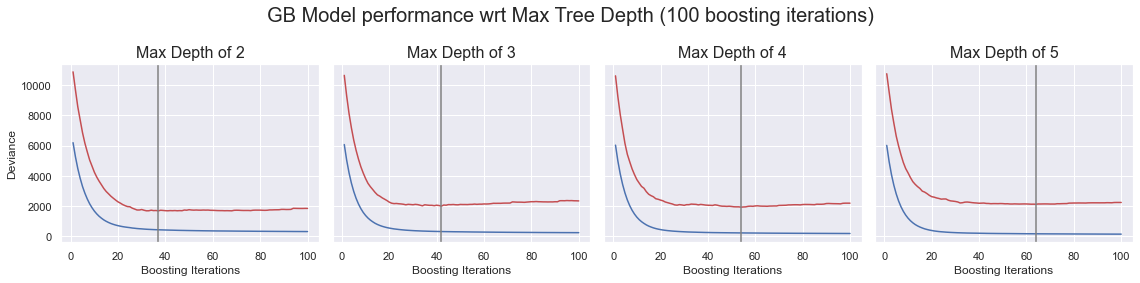

In [81]:
# Plotting max_depth results
fig, axs = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(16, 4))

for i, d in zip(range(0, len(depths)), depths):
    axs[i].plot(
        np.arange(number_of_estimators) + 1,
        depth_results[depths[i]]['train_score'],
        "b-",
        label="Training Set Deviance",
    )
    axs[i].plot(
        np.arange(number_of_estimators) + 1, depth_results[depths[i]]['test_score'], "r-", label="Test Set Deviance"
    )
    
    axs[i].axvline(x=(np.argmin(depth_results[depths[i]]['test_score']) + 1), color='gray')
    axs[i].set_xlabel('Boosting Iterations')
    axs[i].set_title(f'Max Depth of {depths[i]}', fontsize=16);
axs[0].set_ylabel('Deviance')
fig.suptitle('GB Model performance wrt Max Tree Depth (100 boosting iterations)', fontsize=20)
fig.tight_layout()

plt.show()

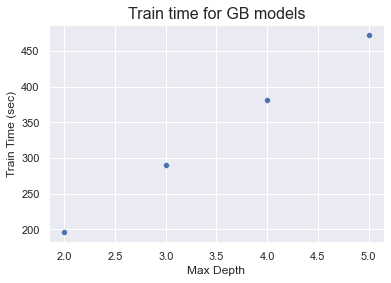

In [76]:
train_times = [x[1]['fit_time'] for x in depth_results.items()]
sns.scatterplot(x=depths, y=train_times);
plt.title('Train time for GB models', fontsize=16);
plt.ylabel('Train Time (sec)')
plt.xlabel('Max Depth')
plt.show()

In [72]:
for x in depth_results.items():
    print(x[1])

{'test_score': array([10877.1072729 ,  9692.55896658,  8571.00780068,  7709.15326897,
        6857.47911935,  6163.85052313,  5596.26221274,  5057.16150171,
        4655.26291532,  4248.52123611,  3928.04315176,  3655.80855426,
        3413.02433172,  3167.07539318,  2971.53316314,  2816.83563247,
        2658.58130855,  2527.90813763,  2402.25279122,  2286.74519579,
        2201.15720328,  2104.64627996,  2034.08441655,  1975.58082236,
        1963.23597853,  1870.88564523,  1811.41208804,  1750.40274461,
        1748.15188831,  1780.79096702,  1731.30445425,  1695.52515208,
        1698.67050415,  1737.13433312,  1709.67792563,  1715.98943821,
        1694.01144226,  1732.01100249,  1719.58171997,  1704.42284136,
        1696.55876799,  1709.39853046,  1702.91040564,  1712.29336662,
        1698.2435618 ,  1707.65744943,  1701.68832303,  1746.87392021,
        1735.04630471,  1769.55838352,  1749.49451572,  1739.4750038 ,
        1748.05485599,  1739.03212253,  1737.4694837 ,  1746.4